# Assignment 2

Veera Anand, Aarav Dewangan, Samuel Martinez Koss, and John Melel.

## Setup + RAPIDS

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
!mamba create -n rapidsai python=3.10 -y


Looking for: ['python=3.10']

[+] 0.0s
conda-forge/linux-64  ⣾  [+] 0.1s
conda-forge/linux-64   1%
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64  11%
conda-forge/noarch    19%[+] 0.3s
conda-forge/linux-64  20%
conda-forge/noarch    40%[+] 0.4s
conda-forge/linux-64  27%
conda-forge/noarch    55%[+] 0.5s
conda-forge/linux-64  30%
conda-forge/noarch    62%[+] 0.6s
conda-forge/linux-64  30%
conda-forge/noarch    62%[+] 0.7s
conda-forge/linux-64  30%
conda-forge/noarch    62%[+] 0.8s
conda-forge/linux-64  33%
conda-forge/noarch    62%[+] 0.9s
conda-forge/linux-64  33%
conda-forge/noarch    68%[+] 1.0s
conda-forge/linux-64  34%
conda-forge/noarch    69%[+] 1.1s
conda-forge/linux-64  35%
conda-forge/noarch    71%[+] 1.2s
conda-forge/linux-64  35%
conda-forge/noarch    73%[+] 1.3s
conda-forge/linux-64  36%
conda-forge/noarch    74%[+] 1.4s
conda-forge/linux-64  38%
conda-forge/noarch    78%[+] 1.5s
conda-forge/linux-64  40%
conda-forge/noarch    84%[+] 1.6s
conda-forge/linux-64  41%


In [ ]:
import os
os._exit(00)

In [1]:
!source activate rapidsai && mamba install -c rapidsai -c conda-forge -c nvidia rapids=23.10 python=3.10 cudatoolkit=11.8 -y


Looking for: ['rapids=23.10', 'python=3.10', 'cudatoolkit=11.8']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
[+] 0.0s
rapidsai/linux-64  ⣾  rapidsai/linux-64                                             No change
nvidia/noarch                                                 No change
rapidsai/noarch                                               No change
nvidia/linux-64                                               No change
Transaction

  Prefix: /usr/local/envs/rapidsai

  Updating specs:

   - rapids=23.10
   - python=3.10
   - cudatoolkit=11.8
   - ca-certificates
   - openssl


  Package                                 Version  Build                              Channel           Size
──────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Install:
──────────────────────────────────────────────────────────────────────────────

In [2]:
!source activate rapidsai && python -c "import cudf; print('RAPIDS version:', cudf.__version__)"

RAPIDS version: 23.10.02


In [3]:
import cudf
import cuml
import cupy

print("cuDF version:", cudf.__version__)
print("cuML version:", cuml.__version__)
print("CuPy version:", cupy.__version__)

cuDF version: 25.02.01
cuML version: 25.02.01
CuPy version: 13.3.0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.4f}'.format

## Question 5

*from* ``0001-03-02-02_multinomial-regression_homework-q1.html``

The ``mnist_784`` dataset can be used for classification tasks. The data and detail information can be found here: https://www.openml.org/search?type=data&sort=runs&id=554&status=active.

### 0.

Load the dataset. Make sure to load the features ($X$) and target ($y$) separately.

In [5]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

In [6]:
X, y = mnist['data'], mnist['target']
y = y.astype(int)

In [7]:
X_cudf = cudf.DataFrame.from_records(X.to_numpy())
y_cudf = cudf.Series(y)

### 1.

Normalize and split the data into training, validation, and testing datasets.

In [8]:
X_train0, X_test0, y_train, y_test = cuml.model_selection.train_test_split(
    X_cudf, y_cudf, train_size=0.7, random_state=23
)

In [9]:
scaler = cuml.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train0)
X_test = scaler.transform(X_test0)

### 2.

Initiate and configure ``LogisticRegression`` in ``sklearn`` for a multinomial regression. Select a range of values of ``C`` and ``l1_ratio`` (hyperparameter space), set up the ``GridSearchCV`` with ``cv`` and select a ``scoring`` to measure the model performance. Execute the model fit.

To use ``GridSearchCV`` with ``RAPIDS`` integration, a wrapper is necessary.

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class RAPIDSLogRegWrapper(BaseEstimator, ClassifierMixin):
  def __init__(self, C=1.0, l1_ratio=0.5):
    self.penalty = 'elasticnet'
    self.C = C
    self.l1_ratio = l1_ratio

  def fit(self, X, y):
    self.model_ = cuml.LogisticRegression(
        penalty=self.penalty,
        C=self.C,
        l1_ratio=self.l1_ratio
    )
    self.model_.fit(X, y)
    return self

  def predict(self, X):
    return self.model_.predict(X).to_numpy()

  def predict_proba(self, X):
    return self.model_.predict_proba(X).to_numpy()

  def score(self, X, y):
    y_pred = self.predict(X)
    return accuracy_score(y.to_numpy(), y_pred)

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 1, 100],
    'l1_ratio': [0.0, 0.5, 1.0],
}

logreg = RAPIDSLogRegWrapper()
logregCV = GridSearchCV(logreg, param_grid, cv=3)
model = logregCV.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/

[2025-04-05 23:43:46.257] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:43:46.259] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:44:18.631] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:44:18.632] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:44:51.141] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:44:51.142] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:45:24.964] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:45:24.970] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:45:57.449] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:45:57.451] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:46:29.819] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:46:29.820] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:47:03.336] [CUML] [warning] L-BFGS: max iterations reached
[2025-04-05 23:47:03.337] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:47:37.025] [CUML] [warning] L-BFGS: max iterations reached
[2025-04-05 23:47:37.030] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:48:10.738] [CUML] [warning] L-BFGS: max iterations reached
[2025-04-05 23:48:10.739] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:48:44.468] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:48:44.469] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:49:16.902] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:49:16.906] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:49:49.309] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:49:49.311] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:50:21.808] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:50:21.810] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:50:54.363] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:50:54.364] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


[2025-04-05 23:51:26.742] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-05 23:51:26.747] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


### 3.

Report the cross-validation results

In [12]:
model.cv_results_

{'mean_fit_time': array([ 6.08302895,  6.38354667,  9.30438519, 15.17789793, 32.53114637,
        32.78674444, 33.53706622, 32.76722725, 32.36833485]),
 'std_fit_time': array([0.53244388, 0.14702949, 0.71273498, 1.221078  , 0.2646607 ,
        0.66341259, 0.07797104, 0.61648529, 0.06385418]),
 'mean_score_time': array([0.12010821, 0.0926168 , 0.09657462, 0.10342113, 0.09274507,
        0.10076404, 0.10221926, 0.10333101, 0.10625076]),
 'std_score_time': array([0.03486422, 0.00220499, 0.00089331, 0.02181814, 0.00245725,
        0.01462698, 0.013675  , 0.01999819, 0.01762157]),
 'param_C': masked_array(data=[0.01, 0.01, 0.01, 1.0, 1.0, 1.0, 100.0, 100.0, 100.0],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=1e+20),
 'param_l1_ratio': masked_array(data=[0.0, 0.5, 1.0, 0.0, 0.5, 1.0, 0.0, 0.5, 1.0],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill

### 4.

Which model was selected?

In [13]:
model.best_estimator_

RAPIDSLogRegWrapper(C=0.01, l1_ratio=0.0)

### 5.

Evaluate the model on the test dataset. Report the ``accuracy score``.

In [14]:
test_preds = model.best_estimator_.predict(X_test)
test_probs = model.best_estimator_.predict_proba(X_test)

In [16]:
print("Test Accuracy:", accuracy_score(y_test.to_numpy(), test_preds))

Test Accuracy: 0.9216190476190477


### 6.

Display a small sample of the images from the testing dataset. Show the associated probability prediction vector for each.

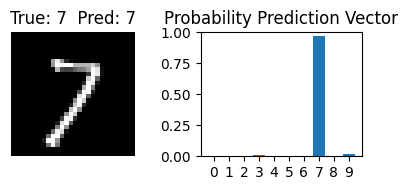

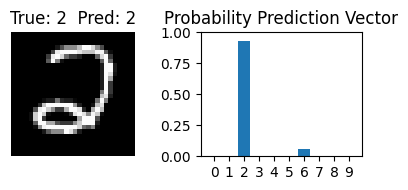

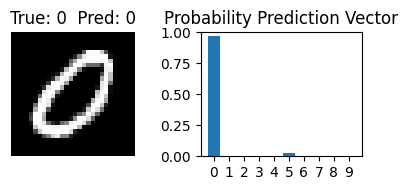

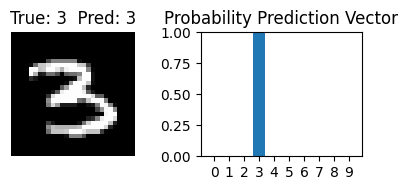

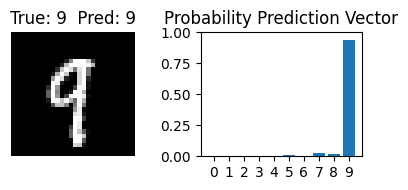

In [42]:
num_samples = 5
rand_i = np.random.choice(len(X_test0), size=num_samples, replace=False)
images = X_test0.iloc[rand_i].to_numpy()
labels = y_test.iloc[rand_i].to_numpy()

for i in np.arange(num_samples):
    plt.figure(figsize=(4, 2))

    plt.subplot(1, 2, 1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'True: {labels[i]}  Pred: {test_preds[rand_i[i]]}')

    plt.subplot(1, 2, 2)
    plt.bar(range(10), test_probs[rand_i[i]])
    plt.xticks(range(10))
    plt.ylim(0, 1)
    plt.title("Probability Prediction Vector")

    plt.tight_layout()
    plt.show()